In [1]:
import pandas as pd
from scipy.stats import binom_test

In [2]:
likes = pd.read_csv('likes.csv')
views = pd.read_csv('views.csv')

Начнём с проверки разбиения групп.

Во-первых, у нас нет таблички соответствия пользователь-группа, так как мы на самом деле определяли группу пользователя прямо перед подготовкой рекомендаций.

Может показаться, что это гарантирует нам однозначное соответствие групп для пользователей, но давайте это проверим. В реальности бывают лаги системы (например, если мы запрашиваем группу пользователя, то не всегда можем получить ответ) и это свойство не выполняется. Проверьте, нет ли у нас пользователей, которые попали в обе группы. Если их совсем немного, удалите их из обеих выборок (если бы было много, то надо было разбираться, что пошло не так).

Теперь, когда мы знаем про однозначное соответствие, сделайте табличку пользователь-группа. Проверьте, что группы получаются одинакового размера по пользователям. Для этого можно посчитать долю каждой группы, а ещё можно применить критерий для долей (биномиальный тест), чтобы проверить соответствие этой доли ожидаемым 0.5.

In [3]:
likes

,user_id,post_id,timestamp
0,128381,4704,1654030804
1,146885,1399,1654030816
2,50948,2315,1654030828
3,14661,673,1654030831
4,37703,1588,1654030833
...,...,...,...
230171,31851,5964,1655243535
230172,51512,1498,1655243537
230173,34017,5009,1655243573
230174,13267,1787,1655243692


In [4]:
views

,user_id,exp_group,recommendations,timestamp
0,128381,control,[3644 4529 4704 5294 4808],1654030803
1,146885,test,[1399 1076 797 7015 5942],1654030811
2,50948,test,[2315 3037 1861 6567 4093],1654030825
3,37703,test,[2842 1949 162 1588 6794],1654030826
4,14661,test,[2395 5881 5648 3417 673],1654030829
...,...,...,...,...
193290,158267,test,[1733 6834 4380 1915 1627],1655240340
193291,63527,control,[2454 191 3873 6404 1588],1655240347
193292,52169,test,[1368 1709 1616 798 5305],1655240354
193293,142402,test,[5895 6984 1978 6548 6106],1655240373


In [5]:
views['exp_group'].value_counts()

exp_group
test       96917
control    96378
Name: count, dtype: int64

In [6]:
# 1. Посчитаем количество уникальных значений групп для каждого пользователя
user_group_counts = views.groupby('user_id')['exp_group'].nunique()

In [7]:
user_group_counts

user_id
200       1
201       1
202       1
212       1
213       1
         ..
168538    1
168541    1
168544    1
168545    1
168552    1
Name: exp_group, Length: 65013, dtype: int64

In [8]:
invalid_users = user_group_counts[user_group_counts > 1].index
print(invalid_users)


Index([25623, 55788, 142283, 148670], dtype='int64', name='user_id')


In [9]:
clean_data = views[~views['user_id'].isin(invalid_users)]

clean_data

,user_id,exp_group,recommendations,timestamp
0,128381,control,[3644 4529 4704 5294 4808],1654030803
1,146885,test,[1399 1076 797 7015 5942],1654030811
2,50948,test,[2315 3037 1861 6567 4093],1654030825
3,37703,test,[2842 1949 162 1588 6794],1654030826
4,14661,test,[2395 5881 5648 3417 673],1654030829
...,...,...,...,...
193290,158267,test,[1733 6834 4380 1915 1627],1655240340
193291,63527,control,[2454 191 3873 6404 1588],1655240347
193292,52169,test,[1368 1709 1616 798 5305],1655240354
193293,142402,test,[5895 6984 1978 6548 6106],1655240373


In [10]:
group_counts = clean_data['exp_group'].value_counts()
print("Количество пользователей в каждой группе:")
print(group_counts)

total_users = len(clean_data)
group_control_count = group_counts.get('control', 0)
group_test_count = group_counts.get('test', 0)

# Биномиальный тест
p_value = binom_test([group_control_count, group_test_count], p=0.5)
print("\nP-значение биномиального теста:", p_value)

Количество пользователей в каждой группе:
exp_group
test       96898
control    96370
Name: count, dtype: int64

P-значение биномиального теста: 0.23062291448605188


C:\Temp\ipykernel_4304\1856752004.py:10: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  p_value = binom_test([group_control_count, group_test_count], p=0.5)


Теперь давайте попробуем оценить, а улучшаются ли наши метрики в тестовой группе.

Наши данные о показах и кликах хранятся в разных табличках и просто так их не получается сджойнить. Давайте оставим это на потом, а пока попробуем оценить более простыми метриками. Подумайте, какие метрики можно было бы посчитать без джойна показов и кликов.

Соберите табличку, в которой будут пользователи, попавшие в наш эксперимент (то есть те, для которых мы строили хотя бы одну рекомендацию). Посчитайте, кто из них сколько лайков сделал. Наверняка будут пользователи, которые не сделали ни один лайк.

Посчитайте долю пользователей, которая сделала хотя бы один лайк за время эксперимента без разбивки на группы.

In [11]:
experiment_users = views[['user_id']].drop_duplicates()

In [12]:
user_likes = likes.groupby('user_id').size().reset_index(name='likes_count')

In [13]:
overall_likes = pd.merge(experiment_users, user_likes, on='user_id', how='left').fillna(0)

In [14]:
overall_likes['liked'] = overall_likes['likes_count'] > 0

In [15]:
overall_likes

,user_id,likes_count,liked
0,128381,7.0,True
1,146885,4.0,True
2,50948,5.0,True
3,37703,6.0,True
4,14661,11.0,True
...,...,...,...
65008,80500,1.0,True
65009,149686,1.0,True
65010,3615,1.0,True
65011,119630,1.0,True


In [16]:
like_ratio = overall_likes['liked'].mean()

print(f"Доля пользователей, сделавших хотя бы один лайк: {like_ratio:.2%}")

Доля пользователей, сделавших хотя бы один лайк: 89.48%


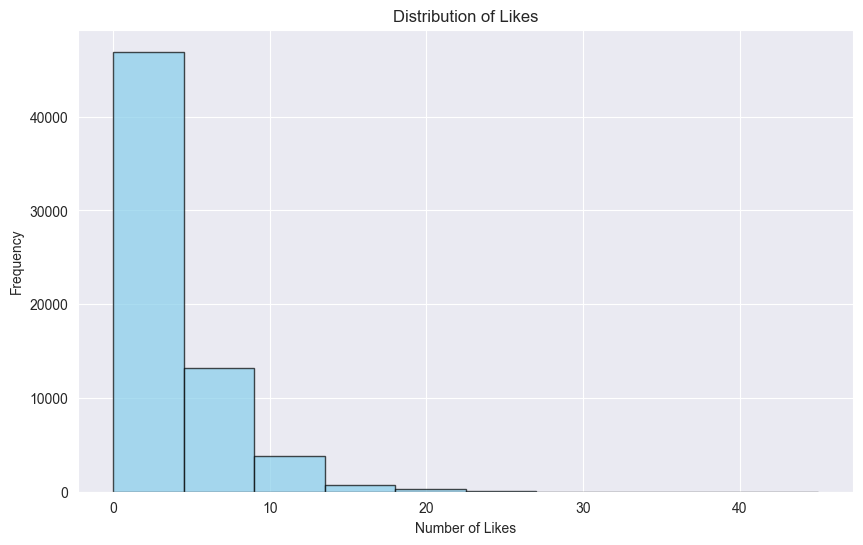

In [17]:
import matplotlib.pyplot as plt

# Создание гистограммы распределения лайков
plt.figure(figsize=(10, 6))
plt.hist(overall_likes['likes_count'], bins=10, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Number of Likes')
plt.ylabel('Frequency')
plt.title('Distribution of Likes')
plt.grid(True)
plt.show()

In [18]:
from scipy.stats import mannwhitneyu

statistic, p_value = mannwhitneyu(likes[likes['user_id'].isin(views[views['exp_group'] == 'control']['user_id'])]['user_id'],
                                   likes[likes['user_id'].isin(views[views['exp_group'] == 'test']['user_id'])]['user_id'])

print("Статистика U:", statistic)
print("p-значение:", p_value)

alpha = 0.05
if p_value < alpha:
    print("Различия в числе лайков на пользователя между группами статистически значимы")
else:
    print("Нет статистически значимых различий в числе лайков на пользователя между группами")

Статистика U: 6571322172.5
p-значение: 0.0013802992391678576
Различия в числе лайков на пользователя между группами статистически значимы


In [19]:
from scipy.stats import mannwhitneyu

# Выполним тест Манна-Уитни
statistic, p_value = mannwhitneyu(overall_likes[overall_likes['user_id'].isin(views[views['exp_group'] == 'control']['user_id'])]['likes_count'],
                                   overall_likes[overall_likes['user_id'].isin(views[views['exp_group'] == 'test']['user_id'])]['likes_count'])

# Выведем результаты
print("Статистика U:", statistic)
print("p-значение:", p_value)

alpha = 0.05
if p_value < alpha:
    print("Различия в доле пользователей хотя бы с одним лайком между группами статистически значимы")
else:
    print("Нет статистически значимых различий в доле пользователей хотя бы с одним лайком")

Статистика U: 518488011.0
p-значение: 2.9682285363509693e-05
Различия в доле пользователей хотя бы с одним лайком между группами статистически значимы


А теперь давайте сделаем самое сложное — посчитаем hitrate (или долю рекомендаций, в которые пользователи кликнули). Для этого мы хотим собрать в одной табличке информацию о показанных постах и соответствующих кликах.

У нас нет айдишника, по которому мы можем сджойнить, но есть два других способа сделать это:

По каждому пользователю отсортировать в обратном по времени порядке все лайки и показы рекомендаций (удобнее прямо в одном списке). Далее в цикле пробежаться по этому списку. Если мы встречаем лайк, то запоминаем его (лайков может быть несколько подряд, надо сохранить все). Если мы встречаем показ рекомендаций, то сохраняем его вместе с уже сохранёнными лайками (так как эти лайки следуют за этим показом рекомендаций в "обычном направлении времени"), при этом список сохранёных лайков очищаем (мы уже приписали эти лайки другим показам). Тем самым мы соединим все показы рекомендаций со всеми лайками после них. Нужно только ещё следить за тем, что может быть лайк, который случился через большое время после показа рекомендаций — скорее всего, мы потеряли другой показ рекомендаций, поэтому такой лайк не надо учитывать.
Сделать join по пользователям всех лайков и всех показов рекомендаций (то есть у нас появятся пары всех показов и всех лайков одного и того же пользователя, но не все эти пары реальны). Далее отфильтровать те ситуации, где лайк предшествовал показу рекомендаций (то есть относился на самом деле к другому показу) или был слишком поздно (тоже относится к другому показу).
Оба эти способа не идеальные и довольно муторные. В pandas проще сделать второй из них. Попробуйте сделать его. В качестве проверки "лайк произошёл слишком поздно после рекомендации" возьмите отсечку 1 час (только лучше сначала просто помечать такие показы, как "отсутствие лайка", потому что если совсем удалять, то можно потерять показ). Добавьте также фильтрацию на то, что в рекомендациях был пост, на который пользователь лайкнул (иначе это точно был другой показ). В самом конце проведите уникализацию всех этих пар в строки показ-лайки (количество лайков может быть нулевым).

На каждом этапе фильтрации следите за размерами таблиц, это поможет вам убедиться, что происходит что-то корректное. Не забудьте учесть тот факт, что могут быть показы рекомендаций без лайков (либо через тип join, либо добавить эти строки в конце). В итоге число строк должно быть похожим на то, которые было сначала в табличке с показами.

Посчитайте долю показов, в которых был хотя бы один лайк.

Сделать join по пользователям всех лайков и всех показов рекомендаций (то есть у нас появятся пары всех показов и всех лайков одного и того же пользователя, но не все эти пары реальны). Далее отфильтровать те ситуации, где лайк предшествовал показу рекомендаций (то есть относился на самом деле к другому показу) или был слишком поздно (тоже относится к другому показу).
Оба эти способа не идеальные и довольно муторные. В pandas проще сделать второй из них. Попробуйте сделать его. В качестве проверки "лайк произошёл слишком поздно после рекомендации" возьмите отсечку 1 час (только лучше сначала просто помечать такие показы, как "отсутствие лайка", потому что если совсем удалять, то можно потерять показ). Добавьте также фильтрацию на то, что в рекомендациях был пост, на который пользователь лайкнул (иначе это точно был другой показ). В самом конце проведите уникализацию всех этих пар в строки показ-лайки (количество лайков может быть нулевым).

На каждом этапе фильтрации следите за размерами таблиц, это поможет вам убедиться, что происходит что-то корректное. Не забудьте учесть тот факт, что могут быть показы рекомендаций без лайков (либо через тип join, либо добавить эти строки в конце). В итоге число строк должно быть похожим на то, которые было сначала в табличке с показами.

Посчитайте долю показов, в которых был хотя бы один лайк.

In [20]:
merged_data = pd.merge(views, likes, on='user_id', how='left')

In [21]:
merged_data

,user_id,exp_group,recommendations,timestamp_x,post_id,timestamp_y
0,128381,control,[3644 4529 4704 5294 4808],1654030803,4704.0,1.654031e+09
1,128381,control,[3644 4529 4704 5294 4808],1654030803,5294.0,1.654031e+09
2,128381,control,[3644 4529 4704 5294 4808],1654030803,3608.0,1.655049e+09
3,128381,control,[3644 4529 4704 5294 4808],1654030803,2542.0,1.655049e+09
4,128381,control,[3644 4529 4704 5294 4808],1654030803,4165.0,1.655053e+09
...,...,...,...,...,...,...
1017168,52169,test,[1368 1709 1616 798 5305],1655240354,1709.0,1.655240e+09
1017169,142402,test,[5895 6984 1978 6548 6106],1655240373,6548.0,1.655240e+09
1017170,72259,control,[6117 1255 6567 3587 3811],1655240388,1712.0,1.654305e+09
1017171,72259,control,[6117 1255 6567 3587 3811],1655240388,5070.0,1.654309e+09


In [88]:
merged_data['recommendations'] = merged_data['recommendations'].str.split()

In [ ]:
merged_data['post_id_y'].fillna(0, inplace=True)  # Заполним пропуски в post_id_y нулями
merged_data['interaction_time'] = merged_data['timestamp_y'] - merged_data['timestamp_x']
merged_data['is_later_like'] = (merged_data['interaction_time'] > 3600) | (merged_data['interaction_time'].isna())
merged_data['is_later_view'] = merged_data['interaction_time'] < 0
merged_data['is_not_recommended'] = merged_data.apply(lambda row: int(row['post_id_x']) not in row['recommendations'], axis=1)

In [ ]:
def count_likes(row):
    if row['is_not_recommended'] or row['is_later_like'] or row['is_later_view']:
        return 0
    post_id = int(row['post_id_x'])
    user_id = row['user_id']
    return sum(1 for like_post_id in row['recommendations'] if like_post_id == post_id and (user_id, post_id, row['timestamp_x']) in zip(likes['user_id'], likes['post_id'], likes['timestamp']))

merged_data['hitrate'] = merged_data.apply(count_likes, axis=1)


In [ ]:
total_views = merged_data.shape[0]
views_with_likes = merged_data[merged_data['hitrate'] > 0].shape[0]
like_frequency = views_with_likes / total_views

print("Относительная частота лайкания:", like_frequency)

А теперь давайте оценим различие между группами и значимость. z-критерий для долей мы здесь не можем применять, так как у нас в каждой выборке один и тот же пользователь может встречаться несколько раз. Давайте применим бакетный подход (то есть перейдём к бакетам и по ним оценим значимость), чтобы посчитать групповой hitrate (или CTR) — доля hitrate по группе/бакету. Используйте 100 бакетов. Уровень значимости останется тем же на уровне 0.05.

Какой вывод мы можем сделать?

In [28]:
import numpy as np
from scipy.stats import chi2_contingency

# Разделение данных на бакеты
n_buckets = 100
merged_data['bucket'] = pd.qcut(merged_data['timestamp_x'], n_buckets, labels=False)

# Вычисление hitrate для каждого бакета
def calculate_hitrate(group):
    return (group['post_id'].notnull()).mean()  # hitrate: доля случаев, когда был хотя бы один лайк

bucket_hitrates = merged_data.groupby('bucket').apply(calculate_hitrate)

# Проверка наличия статистически значимых различий между бакетами
chi2, p_val, *_ = chi2_contingency(np.array([bucket_hitrates.values, np.ones(len(bucket_hitrates))]).T)  # Используем звездочку для игнорирования оставшихся значений

alpha = 0.05

if p_val < alpha:
    print("Существуют статистически значимые различия между бакетами (группами).")
else:
    print("Нет статистически значимых различий между бакетами (группами).")


Нет статистически значимых различий между бакетами (группами).
